<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            45000 non-null  int64 
 1   Title         45000 non-null  object
 2   Body          45000 non-null  object
 3   Tags          45000 non-null  object
 4   CreationDate  45000 non-null  object
 5   Y             45000 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            15000 non-null  int64 
 1   Title         15000 non-null  object
 2   Body          15000 non-null  object
 3   Tags          15000 non-null  object
 4   CreationDate  15000 non-null  object
 5   Y             15000 non-null  object
dtypes: int64(1), object(5)
memory usage: 703.2+ KB
None


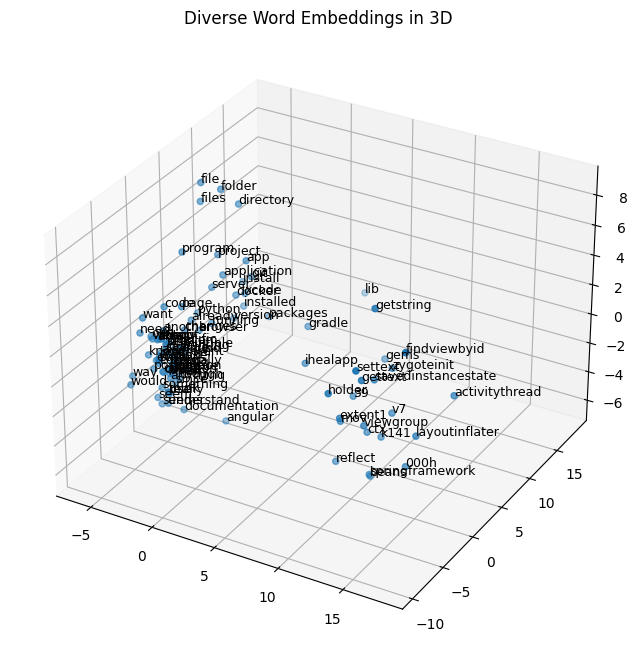

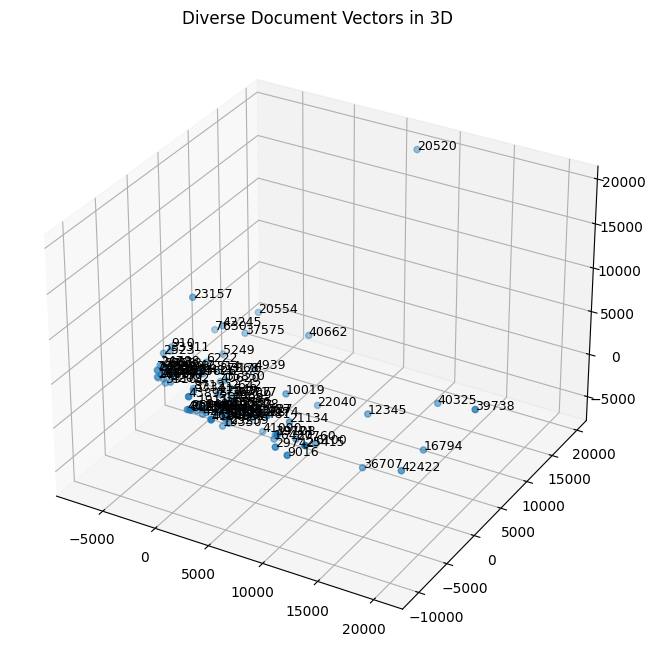

Similarity: 0.82, Title: What are some machine learning algorithms
Similarity: 0.82, Title: Questions about hyperparameter tuning in Keras/Tensorflow
Similarity: 0.79, Title: Hyperparameter Tuning of Tensorflow Model
Similarity: 0.78, Title: Which concurrency model do multiple process/thread programming belong?
Similarity: 0.78, Title: How can I clear a model created with Keras and Tensorflow(as backend)?
Tagging Accuracy: 0.09
Successful Predictions:
                                                 Title  \
19   i am new to pythn and was trying to fix indent...   
33   Hover effect is backward from image. How hover...   
84   Calling an explicit constructor with a braced-...   
93                 how to condense a string of numbers   
103  How to setup input bindings for a component wh...   

                                   Tags  \
19                             <python>   
33                          <html><css>   
84   <c++><c++11><gcc><language-lawyer>   
93                     

In [11]:
# Phase 1: Preprocessing

## 1.1 Load and Explore the Dataset
import pandas as pd
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import warnings

warnings.filterwarnings("ignore")  # Ignore warnings globally

# Load training and validation datasets
data = pd.read_csv('train.csv')
validation_data = pd.read_csv('valid.csv')

# Display basic information
print(data.info())
print(validation_data.info())
data.head()
validation_data.head()

# Load stopwords
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Remove non-alphanumeric characters and lowercase
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text).lower()
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply cleaning to Title and Body
data['cleaned_title'] = data['Title'].apply(clean_text)
data['cleaned_body'] = data['Body'].apply(clean_text)
validation_data['cleaned_title'] = validation_data['Title'].apply(clean_text)
validation_data['cleaned_body'] = validation_data['Body'].apply(clean_text)

# Save cleaned data for further use
data.to_csv('cleaned_train.csv', index=False)
validation_data.to_csv('cleaned_valid.csv', index=False)

# Phase 2: Word2Vec & Similarity Retrieval

## 2.1 Train Word2Vec Model
from gensim.models import Word2Vec

# Tokenize cleaned text into words
data['tokenized_body'] = data['cleaned_body'].apply(lambda x: x.split())
validation_data['tokenized_body'] = validation_data['cleaned_body'].apply(lambda x: x.split())

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=data['tokenized_body'], vector_size=100, window=5, min_count=2, workers=4)

# Save the Word2Vec model
word2vec_model.save('word2vec_model.model')

## 2.2 Visualize Word Embeddings in 3D
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Retrieve the word vectors
words = list(word2vec_model.wv.index_to_key)
word_vectors = word2vec_model.wv[words]

# Select words to ensure diverse scattering
pca_full = PCA(n_components=2)
reduced_full = pca_full.fit_transform(word_vectors)

# Choose words that maximize scatter
scatter_indices = np.argsort(np.sum(reduced_full**2, axis=1))[-100:]
scatter_words = [words[i] for i in scatter_indices]
scatter_vectors = [word_vectors[i] for i in scatter_indices]

# Reduce dimensions to 3D for plotting
pca_scatter = PCA(n_components=3)
scatter_reduced_vectors = pca_scatter.fit_transform(scatter_vectors)

# Plot the 3D visualization for word vectors
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(scatter_reduced_vectors[:, 0], scatter_reduced_vectors[:, 1], scatter_reduced_vectors[:, 2])

# Annotate points with word labels
for i, word in enumerate(scatter_words):
    ax.text(scatter_reduced_vectors[i, 0], scatter_reduced_vectors[i, 1], scatter_reduced_vectors[i, 2], word, fontsize=9)
plt.title("Diverse Word Embeddings in 3D")
plt.show()

# Visualize document vectors
vector_size = word2vec_model.vector_size
data['document_vector'] = data['tokenized_body'].apply(lambda tokens: np.sum([word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv], axis=0) if tokens else np.zeros(vector_size))

# Select documents to ensure diverse scattering
doc_vectors = np.stack(data['document_vector'].values)
pca_doc_full = PCA(n_components=2)
doc_reduced_full = pca_doc_full.fit_transform(doc_vectors)

doc_scatter_indices = np.argsort(np.sum(doc_reduced_full**2, axis=1))[-100:]
doc_scatter_vectors = doc_vectors[doc_scatter_indices]

pca_doc_scatter = PCA(n_components=3)
doc_scatter_reduced = pca_doc_scatter.fit_transform(doc_scatter_vectors)

# Plot the 3D visualization for document vectors
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(doc_scatter_reduced[:, 0], doc_scatter_reduced[:, 1], doc_scatter_reduced[:, 2])

# Annotate points with document IDs
for i, doc_id in enumerate(doc_scatter_indices):
    ax.text(doc_scatter_reduced[i, 0], doc_scatter_reduced[i, 1], doc_scatter_reduced[i, 2], str(doc_id), fontsize=9)
plt.title("Diverse Document Vectors in 3D")
plt.show()

## 2.3 Compute Similarity
from sklearn.metrics.pairwise import cosine_similarity

def get_similar_questions(query, model, data, top_n=5):
    # Preprocess the query
    query = clean_text(query)
    # Generate query vector
    query_vectors = [model.wv[word] for word in query.split() if word in model.wv]
    query_vector = np.sum(query_vectors, axis=0) if query_vectors else np.zeros(model.vector_size)
    query_vector = query_vector.reshape(1, -1)  # Ensure it's 2D

    # Compute similarity with each document
    similarities = []
    for idx, row in data.iterrows():
        # Generate document vector
        doc_vector = row['document_vector'].reshape(1, -1)
        # Calculate cosine similarity
        similarity = cosine_similarity(query_vector, doc_vector)[0][0]
        similarities.append((similarity, row['Title'], row['Body']))

    # Sort by similarity and return top_n results
    similarities = sorted(similarities, key=lambda x: x[0], reverse=True)
    return similarities[:top_n]

# Example usage
query = "How to implement machine learning model?"
similar_questions = get_similar_questions(query, word2vec_model, data)
for sim, title, body in similar_questions:
    print(f"Similarity: {sim:.2f}, Title: {title}")

# Phase 3: Tagging

## 3.1 Prepare Validation Data
validation_data['document_vector'] = validation_data['tokenized_body'].apply(lambda tokens: np.sum([word2vec_model.wv[word] for word in tokens if word in word2vec_model.wv], axis=0) if tokens else np.zeros(vector_size))

## 3.2 Implement KNN for Tag Prediction
from sklearn.neighbors import NearestNeighbors

# Prepare embeddings for documents in the training set
training_vectors = np.stack(data['document_vector'].values)

# Initialize and fit KNN
knn = NearestNeighbors(n_neighbors=5, metric='cosine')
knn.fit(training_vectors)

def predict_tags(validation_data, knn_model, training_data):
    predictions = []
    for idx, row in validation_data.iterrows():
        query_vector = row['document_vector'].reshape(1, -1)
        distances, indices = knn_model.kneighbors(query_vector)
        neighbor_tags = [training_data.iloc[i]['Tags'] for i in indices[0]]
        # Aggregate tags from neighbors
        predicted_tags = list(set([tag for tags in neighbor_tags for tag in tags.split()]))
        predictions.append(predicted_tags)
    return predictions

validation_data['predicted_tags'] = predict_tags(validation_data, knn, data)

## 3.3 Evaluate Tagging Accuracy
def calculate_accuracy(validation_data):
    correct = 0
    total = len(validation_data)
    for idx, row in validation_data.iterrows():
        actual_tags = set(row['Tags'].split())
        predicted_tags = set(row['predicted_tags'])
        if actual_tags.intersection(predicted_tags):
            correct += 1
    return correct / total

accuracy = calculate_accuracy(validation_data)
print(f"Tagging Accuracy: {accuracy:.2f}")

## 3.4 Showcase Examples
# Successful predictions
successful = validation_data[validation_data.apply(lambda x: bool(set(x['Tags'].split()).intersection(set(x['predicted_tags']))), axis=1)]
print("Successful Predictions:")
print(successful[['Title', 'Tags', 'predicted_tags']].head())

# Unsuccessful predictions
unsuccessful = validation_data[~validation_data.apply(lambda x: bool(set(x['Tags'].split()).intersection(set(x['predicted_tags']))), axis=1)]
print("Unsuccessful Predictions:")
print(unsuccessful[['Title', 'Tags', 'predicted_tags']].head())
